In [20]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [21]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j')
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 1851


In [22]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [23]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [j for j in g.neighbors(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for n in neighbors:
            sum += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.739243e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.622885e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,6.018484e+06


In [24]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Germany :', g['France']['Germany'])
print('France - UK :', g['France']['United Kingdom'])

France - Germany : {'weight': 88582.44661152952}
France - UK : {'weight': 62802.53397113779}


In [25]:
# Initialisation for our model :
r0 = 5
alpha = 0.15
beta = 0.4
period = 10
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

# # Initialisation for t=0 :
countries.rename(columns={'population':'population0'}, inplace=True)
countries['incubated0'] = np.zeros(countries.shape[0])
countries['sick0'] = np.zeros(countries.shape[0])
countries['dead0'] = np.zeros(countries.shape[0])
countries['infected0'] = np.zeros(countries.shape[0])
countries['susceptible0'] = countries['population0']

# We infect the starting country with a certain number of people
countries.loc[country_start]['infected0'] = nb_infected_start
countries.loc[country_start]['incubated0'] = nb_infected_start
countries.loc[country_start]['susceptible0'] = countries.loc[country_start]['population0'] - countries.loc[country_start]['incubated0']

The reproduction number ri (average number of people that an incubated person will infect in a week) should :
- be inversly proportionate to the HDI (depending on the beta)
- Decrease with time (as awareness increases, and the immune system adjusts, etc) (depending on the alpha)

Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 6.027027027027026
France : 	 0.894 	 3.35135135135135


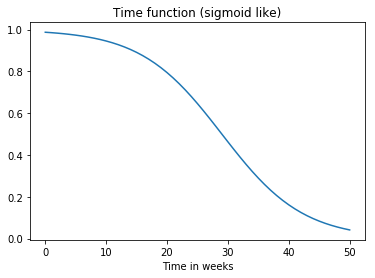

In [26]:
# Contamination decreases with time
def time(t):
    # translation to the right
    x = t-30
    # oposite sigmoid + 1
    return 1 -(1/(1+exp(-alpha*x)))

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    minim=countries.hdi.min()
    maxim=countries.hdi.max()
    # Affine function of HDI :
    a=-2*beta*r0/(maxim-minim)
    b=beta*r0-a*minim
    if t==0:
        return (r0 +a*countries['hdi'] + b)
    else:
        # We calculate the percentage of people that can still be infected
        to_be_infected = countries['susceptible'+str(t)]/ countries['population'+str(t)]
        result = countries['ri'+str(t-1)] * to_be_infected
        return result*time(t)

countries['ri0'] = reproduction_number_by_country(0)
print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri['Afghanistan'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri['France'])

# Plotting our time function
exp_test=[time(t) for t in range(1, 52)]
plt.title("Time function (sigmoid like)")
plt.xlabel("Time in weeks")
plt.plot(exp_test)

In [27]:
# Incubated people staying in the country at time t
def number_incubated_staying(t):
    incubated_staying = {}
    for i in countries.index:
        incubated_staying[i] = countries.loc[i]['incubated'+str(t-1)]*(1 - 
                    countries.loc[i]['travellers']/(countries.loc[i]['population'+str(t-1)] - 
                    countries.loc[i]['dead'+str(t-1)] - countries.loc[i]['sick'+str(t-1)]))
    return incubated_staying
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = {}
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*countries.loc[j]['incubated'+str(t-1)]/(countries.loc[j]['population'+str(t-1)] - 
                                countries.loc[j]['dead'+str(t-1)] - countries.loc[j]['sick'+str(t-1)])
        incubated_coming[i] = sum
    return incubated_coming

incubated_coming = number_incubated_coming(1)
print('Number of incubated staying in France :', number_incubated_staying(1)['France'])
print('Number of incubated coming to France :', incubated_coming['France'])
print('Number of incubated coming to Germany :', incubated_coming['Germany'])
print('Number of incubated coming to the UK :', incubated_coming['United Kingdom'])

sum = 0
for n in return_list_neighbors('France', g):
    sum += incubated_coming[n]
print('For all of France\' neighbors :', sum)

Number of incubated staying in France : 0.9805177621016056
Number of incubated coming to France : 0.0
Number of incubated coming to Germany : 0.001379788888030055
Number of incubated coming to the UK : 0.0009782326163728628
For all of France' neighbors : 0.020675046124605488


In [31]:
def infection_impact(t):
    countries['dead'+str(t)] = mortality_rate*countries['sick'+str(t-1)]
    countries['population'+str(t)] = countries['population'+str(t-1)] - countries['dead'+str(t)]
    countries['susceptible'+str(t)] = countries['susceptible'+str(t-1)] - countries['incubated'+str(t-1)]
    
    countries['ri'+str(t)] = reproduction_number_by_country(t)
    incubated_staying = number_incubated_staying(t)
    incubated_coming = number_incubated_coming(t)
    
    infected = []
    for i in countries.index:
        tmp = (incubated_staying[i] + incubated_coming[i])*(1 + countries.loc[i]['ri'+str(t)])
        if tmp <= countries.loc[i]['population'+str(t)]:
            infected.append(tmp)
        else:
            infected.append(countries.loc[i]['population'+str(t)])
    countries['infected'+str(t)] = infected
    
    countries['sick'+str(t)] = countries['incubated'+str(t - 1)] 
    countries['incubated'+str(t)] = countries['infected'+str(t)] - countries['sick'+str(t)]

print('Country : \t Infected \t Dead')
for p in range(1, period):
    infection_impact(p)
    print(p)
    print('France : \t', round(countries.loc['France']['infected'+str(p)], 3), '\t',
                      round(countries.loc['France']['dead'+str(p)], 3))
    print('Germany : \t', round(countries.loc['Germany']['infected'+str(p)], 3), '\t',
                       round(countries.loc['Germany']['dead'+str(p)], 3))
    print('UK : \t \t', round(countries.loc['United Kingdom']['infected'+str(p)], 3), '\t',
                  round(countries.loc['United Kingdom']['dead'+str(p)], 3))
    print('Afghanistan : \t', round(countries.loc['Afghanistan']['infected'+str(p)], 3), '\t',
                           round(countries.loc['Afghanistan']['dead'+str(p)], 3))

Country : 	 Infected 	 Dead
1
France : 	 4.225 	 0.0
Germany : 	 0.006 	 0.0
UK : 	 	 0.004 	 0.0
Afghanistan : 	 0.0 	 0.0
2
France : 	 13.469 	 0.15
Germany : 	 0.041 	 0.0
UK : 	 	 0.03 	 0.0
Afghanistan : 	 0.0 	 0.0
3
France : 	 42.233 	 0.484
Germany : 	 0.197 	 0.001
UK : 	 	 0.146 	 0.001
Afghanistan : 	 0.001 	 0.0
4
France : 	 129.881 	 1.537
Germany : 	 0.814 	 0.005
UK : 	 	 0.609 	 0.004
Afghanistan : 	 0.011 	 0.0
5
France : 	 390.559 	 4.798
Germany : 	 3.056 	 0.024
UK : 	 	 2.31 	 0.018
Afghanistan : 	 0.075 	 0.0
6
France : 	 1144.264 	 14.684
Germany : 	 10.693 	 0.098
UK : 	 	 8.174 	 0.073
Afghanistan : 	 0.447 	 0.001
7
France : 	 3252.931 	 43.9
Germany : 	 35.27 	 0.361
UK : 	 	 27.238 	 0.273
Afghanistan : 	 2.488 	 0.01
8
France : 	 8930.24 	 127.74
Germany : 	 110.111 	 1.243
UK : 	 	 85.852 	 0.953
Afghanistan : 	 13.012 	 0.057
9
France : 	 23544.493 	 360.2
Germany : 	 325.541 	 4.047
UK : 	 	 256.059 	 3.133
Afghanistan : 	 64.366 	 0.316


In [42]:
country_status=pd.DataFrame(np.zeros(shape=(countries.shape[0], period)), index = countries.index, 
                            columns = range(period))
epidemic_threshold=200/100000

# Initialization at t=0, all countries are susceptible except the exposed country
country_status.replace(to_replace= 0, value = 'Susceptible',inplace=True)

# Replacing the Epidemic and the Exposed:
for i in country_status.index:
    for t in range(period):
        if countries.loc[i]['infected'+str(t)] / countries.loc[i]['population'+str(t)] > epidemic_threshold:
            country_status.loc[i][t] = 'Epidemic'
        elif countries.loc[i, 'infected'+str(t)] >= 1:
            country_status.loc[i][t] = 'Exposed'

# Replacing the Recovered:
for i in country_status.index:
    for t in range(1, period):
        if ((country_status.loc[i][t-1] == 'Epidemic')
        and countries.loc[i]['infected'+str(t)] / countries.loc[i]['population'+str(t)] < epidemic_threshold):
            country_status.loc[i][t]='Recovered'

        
country_status.head()

,0,1,2,3,4,5,6,7,8,9
country,,,,,,,,,,
Afghanistan,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,Exposed
Albania,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed
Algeria,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,Exposed,Exposed
Angola,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed,Exposed,Exposed
Antigua and Barbuda,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Susceptible,Exposed,Exposed


In [49]:
for t in range(period):
    nx.set_node_attributes(g, countries['infected'+str(t)].to_dict(), 'infected'+str(t))
    nx.set_node_attributes(g, country_status[t].to_dict(), str(t))

{'Afghanistan': 0.07453819003042128,
 'Azerbaijan': 0.7568071566343534,
 'India': 4.125885011822086,
 'Iran': 1.9535658506197286,
 'Kuwait': 0.02163958683735538,
 'Tajikistan': 0.00020140702593364905,
 'Turkey': 0.6624807643189272,
 'United Arab Emirates': 2.864472334239664,
 'Albania': 0.011157982995801863,
 'Austria': 0.5467157618252348,
 'Germany': 3.0555358654886677,
 'Greece': 0.4862957589711497,
 'Italy': 1.5181211656369737,
 'Slovenia': 0.350902178280362,
 'United Kingdom': 2.3103689569912764,
 'Algeria': 0.5128244519614762,
 'Belgium': 0.5899499461094627,
 'Burkina Faso': 0.556811403911605,
 'Canada': 1.5786348195086068,
 'China': 13.508763437169502,
 "Cote d'Ivoire": 1.2090921875957883,
 'Egypt': 1.8009747169646617,
 'France': 390.5591336828376,
 'Jordan': 0.12933141746535864,
 'Lebanon': 0.23296369648234563,
 'Libya': 0.00788137598479331,
 'Malta': 0.02024012172362539,
 'Morocco': 1.0412989464466473,
 'Niger': 0.008099233383196873,
 'Portugal': 0.09917513905552036,
 'Russia':

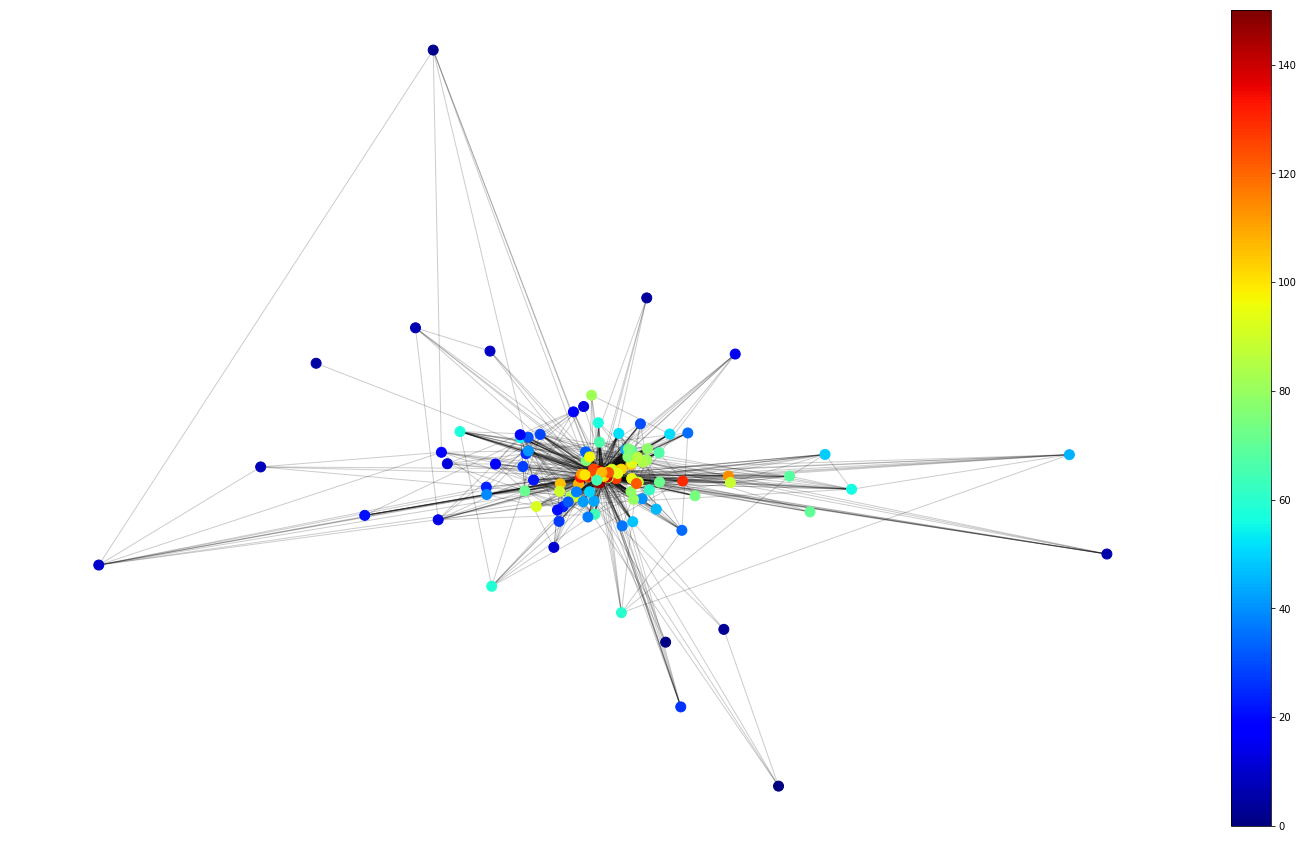

In [55]:
# get unique groups
groups = set(nx.get_node_attributes(g,'infected5').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.node[n]['infected5']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
f, ax = plt.subplots(figsize=(25,15))
ax = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap as Basemap